In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.special import expit, logit
from scipy.optimize import fsolve
import statsmodels.api as sm

## Validating Instrumental Variables

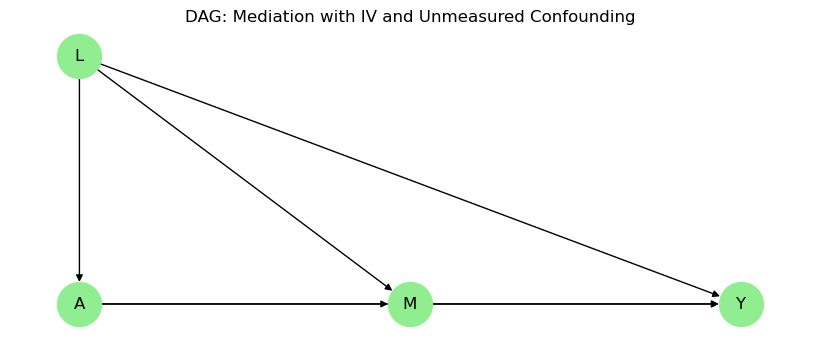

In [2]:
def draw_dag():
    G = nx.DiGraph()
    edges = [("L", "A"), ("L", "M"), ("L", "Y"), ("A", "M"), ("A", "Y"), ("M", "Y")]
    G.add_edges_from(edges)
    pos = {"L": (2, 2), "A": (2, 1), "M": (4, 1), "Y": (6, 1)}
    plt.figure(figsize=(8, 3))
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1000, arrowsize=10)
    plt.title("DAG: Mediation with IV and Unmeasured Confounding")
    plt.show()

draw_dag()

In [26]:
import numpy as np
import pandas as pd
from scipy.special import expit
from scipy.optimize import fsolve
import statsmodels.api as sm

def refined_validation():
    np.random.seed(42)
    N = 10**6 
    
    Z = np.random.binomial(1, 0.5, N)
    L = np.random.normal(0.5, 0.1, N) 
    
    A = np.random.binomial(1, expit(-1 + 1.5 * Z + 0.5 * L))
    M = np.random.binomial(1, expit(-2 + 2.0 * A + 0 * L))
    Y = np.random.binomial(1, expit(-3 + 1.0 * A + 1.5 * M - 1.0 * L))
    
    def g_equation(psi, instrument, expected_instr, exposure, outcome_logit_pred):
        h_psi = expit(outcome_logit_pred - exposure * psi)
        return np.sum((instrument - expected_instr) * h_psi)

    X_z = sm.add_constant(np.column_stack((A, M, L)))
    res_z = sm.Logit(Y, X_z).fit(disp=0)
    #pred_logit_z = res_z.predict(X_z, linear=True)
    
    X_z2 = sm.add_constant(np.column_stack((A, Z, M, L)))
    res_z2 = sm.Logit(Y, X_z2).fit(disp=0)
    pred_logit_z = res_z2.predict(X_z2, linear=True)
    
    pz = np.mean(Z)
    psi_z = fsolve(g_equation, x0=1.0, args=(Z, pz, A, pred_logit_z))[0]

    # delete this
#     X_a = sm.add_constant(np.column_stack((A, M, L)))
#     res_a = sm.Logit(Y, X_a).fit(disp=0)
#     pred_logit_a = res_a.predict(X_a, linear=True)
    
#     res_prob_a = sm.Logit(A, sm.add_constant(L)).fit(disp=0)
#     pa_l = res_prob_a.predict(sm.add_constant(L))
    
#     psi_a = fsolve(g_equation, x0=1.0, args=(A, pa_l, A, pred_logit_a))[0]

    return psi_z, res_z.params, res_z2.params

psi_z, res_z_params, res_z2_params = refined_validation()
print(res_z_params)
print(res_z2_params)
print(f"Psi using G-estimation (with Z): {psi_z:.4f}")


[-2.97156024  1.00734562  1.50268307 -1.07252699]
[-2.6754119   1.61644023 -0.00604024 -1.01254216]
Psi using G-estimation (with Z): 1.5997


In [18]:
    np.random.seed(42)
    N = 10**6 
    
    Z = np.random.binomial(1, 0.5, N)
    L = np.random.normal(0.5, 0.1, N) 
    
    A = np.random.binomial(1, expit(-1 + 1.5 * Z + 0.5 * L))
    M = np.random.binomial(1, expit(-2 + 2.0 * A + 0.5 * L))
    Y = np.random.binomial(1, expit(-3 + 1.0 * A + 0 * M - 1.0 * L))
    
    def g_equation(psi, instrument, expected_instr, exposure, outcome_logit_pred):
        h_psi = expit(outcome_logit_pred - exposure * psi)
        return np.sum((instrument - expected_instr) * h_psi)

    X_z = sm.add_constant(np.column_stack((A, Z, L)))
    res_z = sm.Logit(Y, X_z).fit(disp=0)
    pred_logit_z = res_z.predict(X_z, linear=True)
    
    pz = np.mean(Z)
    psi_z = fsolve(g_equation, x0=1.0, args=(Z, pz, A, pred_logit_z))[0]
    
    psi_z, res_z.params

(0.9930383866696066,
 array([-2.95838509,  1.01259378, -0.00705723, -1.09153067]))